In [1]:
import torch
from torch import nn
from torch.utils.data import dataset,DataLoader, sampler
from torchvision import transforms
from torch.autograd import Variable
import numpy as np
import torchvision

batch_size = 128
NUM_TRAIN = 50000
NUM_VAL = 5000
NOISE_DIM = 96

In [2]:
def preprocess_img(x):
    x = transforms.ToTensor()(x)
    return (x - 0.5) / 0.5
def deprocess_img(x):
    return (x + 1.0) / 2.0

    


In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams['figure.figsize'] = (10.0, 8.0) # 设置画图的尺寸
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images): # 定义画图工具
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

In [4]:
#check smaple
class ChunkSampler(sampler.Sampler):
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start
    
    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))
        
    def __len__(self):
        return self.num_samples

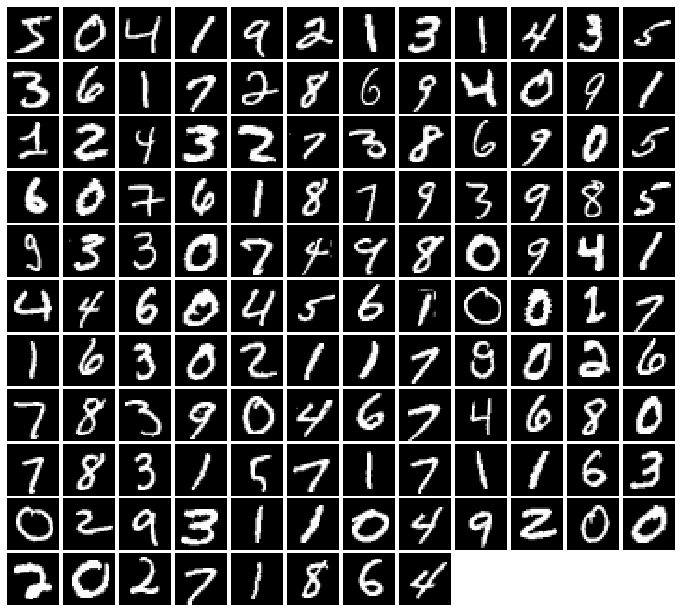

In [5]:
#download dataset MINIST
train_set = torchvision.datasets.MNIST('data', train = True, transform = preprocess_img)
train_data = DataLoader(train_set, batch_size = batch_size, sampler = ChunkSampler(NUM_TRAIN, 0))

val_set = torchvision.datasets.MNIST("data", train = True, transform = preprocess_img)
val_train = DataLoader(val_set, batch_size = batch_size, sampler = ChunkSampler(NUM_VAL, NUM_TRAIN))

imgs = deprocess_img(train_data.__iter__().next()[0].view(batch_size, 784)).numpy().squeeze() # 可视化图片效果
show_images(imgs)

In [6]:
# set net of discrimator
class build_d_net(nn.Module):
    def __init__(self):
        super(build_d_net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5, 1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 5, 1), 
            nn.LeakyReLU(0.01), 
            nn.MaxPool2d(2, 2))
        self.fc = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.01), 
            nn.Linear(1024, 1))
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x
#set net of generateor
class build_g_net(nn.Module):
    def __init__(self, noise_dim = NOISE_DIM):
        super(build_g_net, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(noise_dim, 1024), 
            nn.ReLU(1024), 
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 7 * 7 * 128), 
            nn.ReLU(True), 
            nn.BatchNorm1d(7 * 7 * 128)
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, padding=1), 
            nn.ReLU(True), 
            nn.BatchNorm2d(64), 
            nn.ConvTranspose2d(64, 1, 4, 2, padding = 1), 
            nn.Tanh()
        )
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.shape[0], 128, 7, 7)
        x = self.conv(x)
        return x

In [7]:
#loss_fn
bce_loss = nn.BCEWithLogitsLoss()

#two part of true pic and false pic
def discriminator_loss(logits_real, logits_fake):
    size = logits_real.shape[0]
    true_labels = Variable(torch.ones(size, 1)).float().cuda()
    false_labels = Variable(torch.zeros(size, 1)).float().cuda()
    loss = bce_loss(logits_real, true_labels) + bce_loss(logits_fake, false_labels)
    return loss
    
def generator_loss(logits_fake):
    size = logits_fake.shape[0]
    true_labels = Variable(torch.ones(size, 1)).float().cuda()
    loss = bce_loss(logits_fake, true_labels)
    return loss

In [8]:
#set adma optimizer
def get_optimizer(net):
    optimizer = torch.optim.Adam(net.parameters(), lr = 3e-4, betas = (0.5, 0.999))
    return optimizer

In [13]:
#set train and save picture
def train_dc_gan(D_net, G_net, D_optimizer, G_optimizer, D_loss_fn, G_loss_fn, noise_size = 96, num_epochs = 10, show_every=250):
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in train_data:
            bs = x.shape[0]
            #discrimiator net
            real_data = Variable(x).cuda()# real data
            logits_real = D_net(real_data)#score of discrimator net

            sample_noise = (torch.rand(bs, noise_size) - 0.5) / 0.5   #-1 to 1 average disfulse
            g_fake_seed = Variable(sample_noise).cuda()

            fake_images = G_net(g_fake_seed)#   fake data
            logits_fake = D_net(fake_images)#score of discrimator net
            
            d_total_error = D_loss_fn(logits_real, logits_fake) # 判别器的 loss
            D_optimizer.zero_grad()
            d_total_error.backward()
            D_optimizer.step() # 优化判别网络
            
            # 生成网络
            g_fake_seed = Variable(sample_noise).cuda()
            fake_images = G_net(g_fake_seed) # 生成的假的数据

            gen_logits_fake = D_net(fake_images)
            g_error = G_loss_fn(gen_logits_fake) # 生成网络的 loss

            G_optimizer.zero_grad()
            g_error.backward()
            G_optimizer.step() # 优化生成网络

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count, d_total_error.item(), g_error.item()))
                imgs_numpy = deprocess_img(fake_images.data.cpu().numpy())
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1
#保存网络模型
            torch.save(D_DC.state_dict(), '.pth/gan_generate_nums_discramitor.pth')
            torch.save(G_DC.state_dict(), '.pth/gan_generate_nums_generator.pth')
def test_dc_gan(G_net, noise_size = 96):
    for x, _ in train_data:
        bs = x.shape[0]

        sample_noise = (torch.rand(bs, noise_size) - 0.5) / 0.5   #-1 to 1 average disfulse
        g_fake_seed = Variable(sample_noise).cuda()

        fake_images = G_net(g_fake_seed)#   fake data
            
        # 生成网络
        g_fake_seed = Variable(sample_noise).cuda()
        fake_images = G_net(g_fake_seed) # 生成的假的数据

        imgs_numpy = deprocess_img(fake_images.data.cpu().numpy())
        show_images(imgs_numpy[0:16])
        plt.show()
        print()
        break


discrimator finsih
generator finish


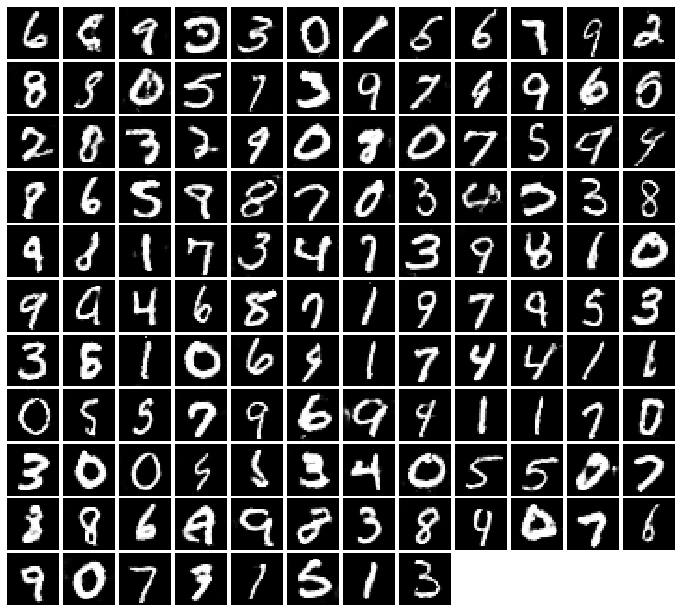

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7,
        1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7, 4, 6, 8, 0,
        7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2, 9, 3, 1, 1, 0, 4, 9, 2, 0, 0,
        2, 0, 2, 7, 1, 8, 6, 4])



In [14]:
import os
#加载判别器和生成器
if os.path.exists('.pth/gan_generate_nums_discramitor.pth'):
    D_DC = build_d_net()
    D_DC.load_state_dict(torch.load('.pth/gan_generate_nums_discramitor.pth'))
    D_DC = D_DC.cuda()
    print('discrimator finsih')
else:
    D_DC = build_d_net().cuda()

if os.path.exists('.pth/gan_generate_nums_generator.pth'):
    G_DC = build_g_net()
    G_DC.load_state_dict(torch.load('.pth/gan_generate_nums_generator.pth'))
    G_DC = G_DC.cuda()
    print('generator finish')
else:
    G_DC = build_g_net().cuda()

D_DC_optim = get_optimizer(D_DC)
G_DC_optim = get_optimizer(G_DC)
#生成虚假的0-1的数字
test_dc_gan(G_DC)
#训练模型（生成器和判别器，需要训练取消注释）
# train_dc_gan(D_DC, G_DC, D_DC_optim, G_DC_optim, discriminator_loss, generator_loss, num_epochs=20)





